Perform simulations for an atomic liquid.

Potential: Truncated Shifted LJ

Cutoff: 2.5$\sigma$ 

N: 256 

T: 1.32

$\rho \in [0.4,0.8]$, 9 values

$\rightarrow$ First lets write a function that generates a random configuration, with the constraint that no two particles are closer than $0.8\sigma$. We randomly place particles such that the constraint is satisfied. If the constraint fails, then a new random placement is attempted.

In [1]:
#### using DelimitedFiles

function populate(rho::Float64,n::Int64)
    vol = n/rho
    box_size = cbrt(vol)
    xpos = zeros(n)
    ypos = zeros(n)
    zpos = zeros(n)
    xpos[1] = (rand() - 0.5)*box_size
    ypos[1] = (rand() - 0.5)*box_size
    zpos[1] = (rand() - 0.5)*box_size
    i=2
    while(i<=n)
        xpos[i] = (rand() - 0.5)*box_size
        ypos[i] = (rand() - 0.5)*box_size
        zpos[i] = (rand() - 0.5)*box_size
        flag=true
        for j in 1:(i-1)
            if(flag)
                dx = xpos[i] - xpos[j]
                dy = ypos[i] - ypos[j]
                dz = zpos[i] - zpos[j]
                dx = dx - box_size*round(dx/box_size)
                dy = dy - box_size*round(dy/box_size)
                dz = dz - box_size*round(dz/box_size)
                r2 = dx^2 + dy^2 + dz^2
                if(r2 < 0.64)
                    i = i - 1
                    flag=false
                end
            end
        end
        i = i + 1
    end
end

for i in 1:9
    populate(0.4 + 0.05*(i - 1), 256)
    #println("done")
    #sleep(0.1)
end

In [1]:
function populate(rho::Float64,n::Int64)
    vol = n/rho
    box_size = cbrt(vol)
    xpos = zeros(n)
    ypos = zeros(n)
    zpos = zeros(n)
    xpos[1] = (rand() - 0.5)*box_size
    ypos[1] = (rand() - 0.5)*box_size
    zpos[1] = (rand() - 0.5)*box_size
    i=2
    while(i<=n)
        xpos[i] = (rand() - 0.5)*box_size
        ypos[i] = (rand() - 0.5)*box_size
        zpos[i] = (rand() - 0.5)*box_size
        flag=true
        for j in 1:(i-1)
            if(flag)
                dx = xpos[i] - xpos[j]
                dy = ypos[i] - ypos[j]
                dz = zpos[i] - zpos[j]
                dx = dx - box_size*round(dx/box_size)
                dy = dy - box_size*round(dy/box_size)
                dz = dz - box_size*round(dz/box_size)
                r2 = dx^2 + dy^2 + dz^2
                if(r2 < 0.64)
                    i = i - 1
                    flag=false
                end
            end
        end
        i = i + 1
    end
    return xpos,ypos,zpos,box_size
end

populate (generic function with 1 method)

Lets write the pair-wise interaction potential. The Lennard-Jones potential, with $r_{ij} = |\vec{r}_i - \vec{r}_j| = |\vec{r}_{ij}|$
\begin{equation}
U_{LJ}(r_{ij}) = 4\epsilon\left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right]
\end{equation}
is truncated at $\sigma = \sigma_c = 2.5\sigma$ and shifted such that it goes to zero at $\sigma_c$
\begin{eqnarray}
U_{TSLJ}(r_{ij}) &=& U_{LJ}(r_{ij}) - U_{LJ}(\sigma_c) \quad \quad r_{ij}\leq\sigma_c \\
U_{TSLJ}(r_{ij}) &=& 0 \quad \quad \quad \quad \quad \quad \quad \quad r_{ij}>\sigma_c
\end{eqnarray}

The function below returns the pairwise interaction energy **and** the scalar force times $r_{ij}$.

In [2]:
function stlj_pot(r::Float64)
	return 4*((1.0/r)^12 - (1.0/r)^6) - 0.016316891136,4*(12*((1.0/r)^12) - 6*((1.0/r)^6))
end

stlj_pot (generic function with 1 method)

Lets write the function that implements the periodic boundary condition.

In [3]:
function apply_pbcs(x::Float64,y::Float64,z::Float64,box_size::Float64)
	iBox = 1.0/box_size
	x = x - box_size*round(x*iBox) 
	y = y - box_size*round(y*iBox)
	z = z - box_size*round(z*iBox)
	return x,y,z
end

apply_pbcs (generic function with 1 method)

Lets implement the Verlet Neighbour List with a skin depth of $0.5\sigma_c$. I use a $1D$ array **verlet_list** to store the neighbours of each particle. For the i'th particle the first element in the corresponding block in verlet_list is the number of neighbours of $i$.

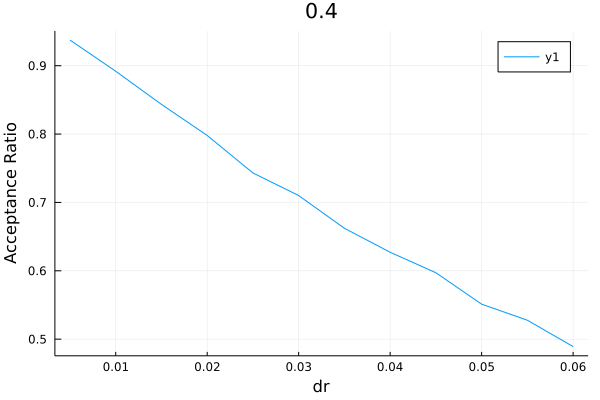

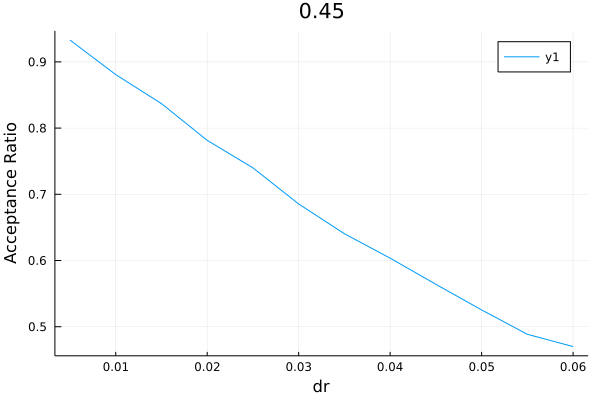

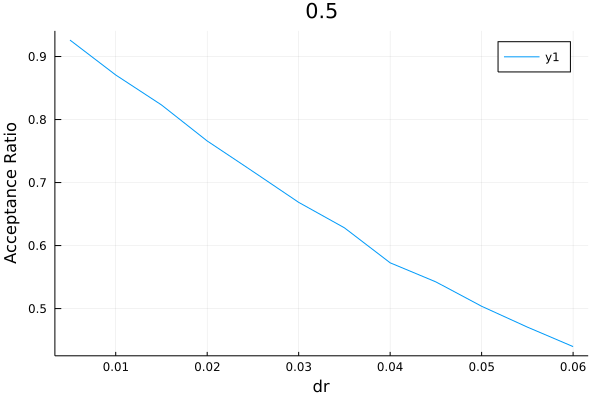

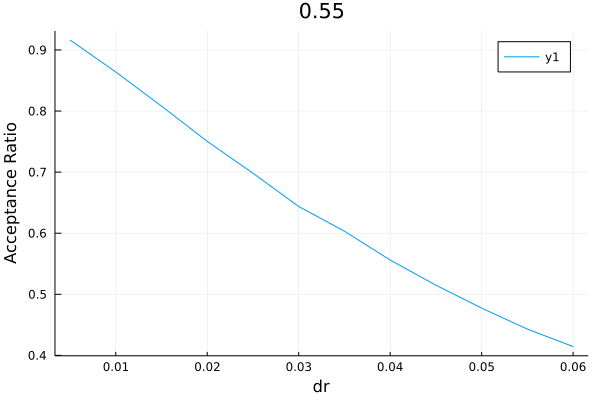

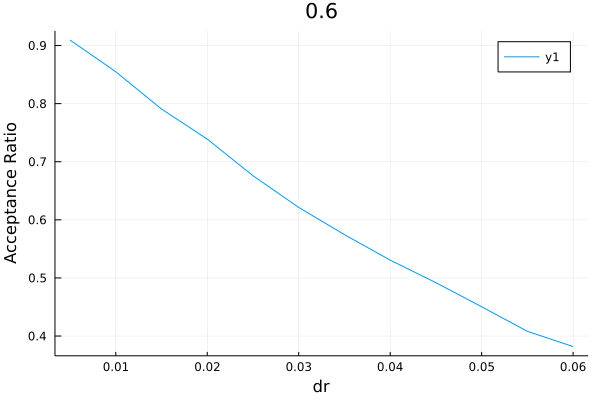

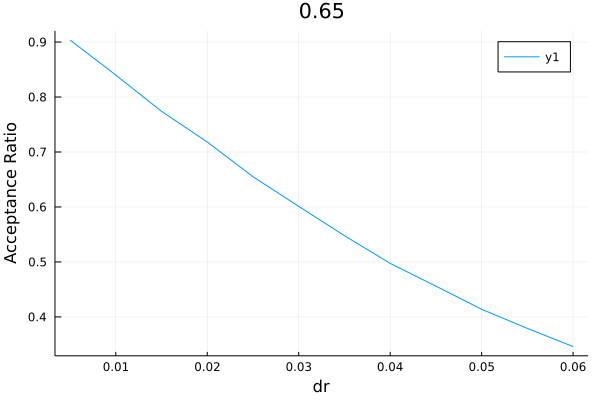

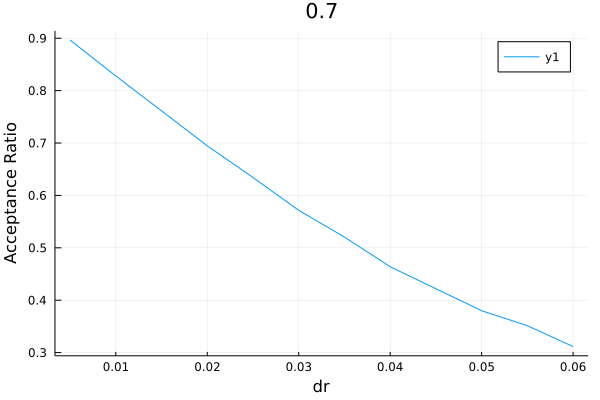

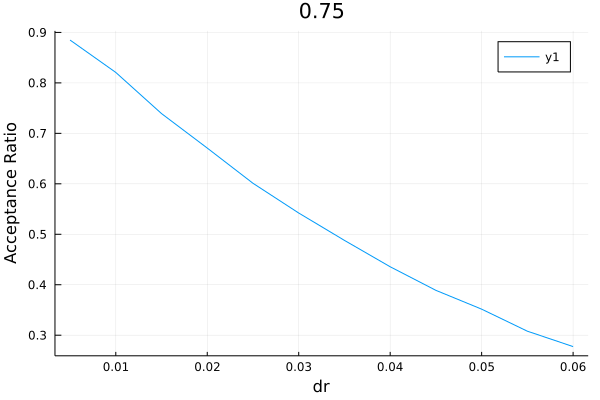

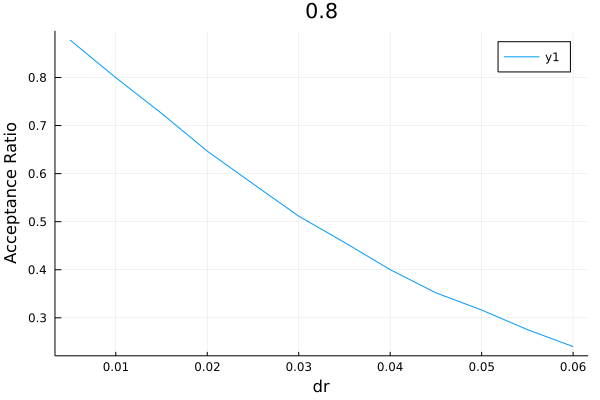

In [7]:
using Plots


#tested
function verlet_list_new(xpos::Array{Float64,1},ypos::Array{Float64,1},zpos::Array{Float64,1},box_size::Float64,n::Int64)
	verlet_list = Int64[]
	seeker = zeros(Int64,n)
	nnei_index::Int64 = 1
	for i in 1:n
		nnei::Int64 = 0
		push!(verlet_list,nnei)
		for j in 1:n
			if(i!=j)
				r2 = 0.0
				dx = xpos[i] - xpos[j]
				dy = ypos[i] - ypos[j]
				dz = zpos[i] - zpos[j]
				dx = dx - box_size*round(dx/box_size)
				dy = dy - box_size*round(dy/box_size)
				dz = dz - box_size*round(dz/box_size)
				r2 = dx*dx + dy*dy + dz*dz
				if(r2<=9.0)
					push!(verlet_list,j)
					nnei = nnei + 1
				end
			end
		end
		verlet_list[nnei_index] = nnei
		seeker[i] = nnei_index + 1
		nnei_index = nnei_index + nnei + 1
	end
	#println(verlet_list)
	#pos_snap = copy(pos)
	return verlet_list,seeker
end

function calc_tot_energy(xpos::Array{Float64,1},ypos::Array{Float64,1},zpos::Array{Float64,1},nlist::Array{Int64,1},seeker::Array{Int64,1},box_size::Float64,n::Int64)
    total_energy = 0.0
    pressure = 0.0
    for i in 1:n
        for j in nlist[seeker[i]:(seeker[i] + nlist[seeker[i] - 1] -1)]
            drx = xpos[i] - xpos[j]
            dry = ypos[i] - ypos[j]
            drz = zpos[i] - zpos[j]
            drx,dry,drz = apply_pbcs(drx,dry,drz,box_size)
            dr2 = drx*drx + dry*dry + drz*drz
            dr = sqrt(dr2)
            if (dr2<6.25)
                pair_energy,scalar_force = stlj_pot(dr)
                total_energy = total_energy + 0.5*pair_energy
                pressure = pressure + 0.5*dr2*scalar_force
            end
        end
	end
    return total_energy, pressure/(3.0*(box_size^3))
end
            

@views function mcmove!(xpos::Array{Float64,1},ypos::Array{Float64,1},zpos::Array{Float64,1},nlist::Array{Int64,1},seeker::Array{Int64,1},box_size::Float64,n::Int64,jump::Float64,beta::Float64,acc_ratio::Array{Float64,1})

	p = rand(1:n)
	e_old = 0.0
	e_new = 0.0
	pstart = seeker[p]
	pstop = seeker[p] + nlist[seeker[p] - 1] - 1
	
	drx = 0.0
	dry = 0.0
	drz = 0.0
	for j in nlist[pstart:pstop]
		drx = xpos[p] - xpos[j]
		dry = ypos[p] - ypos[j]
		drz = zpos[p] - zpos[j]
		drx,dry,drz = apply_pbcs(drx,dry,drz,box_size)
		dr = sqrt(drx*drx + dry*dry + drz*drz)
		if (dr<2.5)
			pair_energy,scalar_force = stlj_pot(dr)
			e_old = e_old + pair_energy
		end
	end


    dx = (rand(Float64) - 0.5)*jump*box_size
    dy = (rand(Float64) - 0.5)*jump*box_size
    dz = (rand(Float64) - 0.5)*jump*box_size
	#dist = sqrt(dx*dx + dy*dy + dz*dz)

    xpos_old = xpos[p]
    ypos_old = ypos[p]
    zpos_old = zpos[p]
    xpos[p] += dx
    ypos[p] += dy
    zpos[p] += dz

	#if (dist>1.4)
	#	nlist,seeker = verlet_list_new(xpos,ypos,zpos,r,seeker,box_size,n,0.0)
	#	println("shout")
	#end

	drx = 0.0
	dry = 0.0
	drz = 0.0
	for j in nlist[pstart:pstop]
		drx = xpos[p] - xpos[j]
		dry = ypos[p] - ypos[j]
		drz = zpos[p] - zpos[j]
		drx,dry,drz = apply_pbcs(drx,dry,drz,box_size)
		dr = sqrt(drx*drx + dry*dry + drz*drz)
		if (dr<2.5)
			pair_energy,scalar_force = stlj_pot(dr)
			e_new = e_new + pair_energy
		end
	end
	deltaE = e_new - e_old
	acc_prob = exp(-beta*deltaE)
	if (rand(Float64)>acc_prob)
        xpos[p] -= dx
        ypos[p] -= dy
        zpos[p] -= dz
        acc_ratio[1] = acc_ratio[1] + 1.0
    end
end

function mc_main(rho::Float64,jump::Float64,timesteps::Int64)
    n = 256
    xpos,ypos,zpos,box_size = populate(rho,n)
    temp = 1.32
	beta = 1.0/temp

	seeker = zeros(Int64,n)
	nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
	xpos_snap = copy(xpos)
	ypos_snap = copy(ypos)
	zpos_snap = copy(zpos)
	pe = zeros(timesteps)
    pressure = zeros(timesteps)
    acc_ratio = [0.0,0.0]
	dRx::Float64 = 0.0
	dRy::Float64 = 0.0
	dRz::Float64 = 0.0

	for t = 1:timesteps
		for i = 1:n
            mcmove!(xpos,ypos,zpos,nlist,seeker,box_size,n,jump,beta,acc_ratio)
        end
        pe[t],pressure[t] = calc_tot_energy(xpos,ypos,zpos,nlist,seeker,box_size,n)
		dR_max1 = 0.0
		dR_max2 = 0.0
		for i = 1:n
			dRx = xpos[i] - xpos_snap[i]
			dRy = ypos[i] - ypos_snap[i]
			dRz = zpos[i] - zpos_snap[i]
			dRx,dRy,dRz = apply_pbcs(dRx,dRy,dRz,box_size)
			dx = dRx*dRx + dRy*dRy + dRz*dRz
			dx = sqrt(dx)
			if(dx>dR_max1)
				dR_max2 = dR_max1
				dR_max1 = dx
			elseif(dx>dR_max2)
				dR_max2 = dx
			end
		end
		if(dR_max1 + dR_max2 > 0.5)
			nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
			xpos_snap = copy(xpos)
			ypos_snap = copy(ypos)
			zpos_snap = copy(zpos)
		end
	end
    acc_ratio[1] = acc_ratio[1]/(n*timesteps)
    acc_ratio[1] = 1 - acc_ratio[1]
	return acc_ratio[1]
end


for rho in 0.4:0.05:0.8
    step = 1
    accratio = zeros(12)
    for jump in 0.005:0.005:0.06
        accratio[step] = mc_main(rho,jump,500)
        step = step + 1
    end
    Plots.display(plot(0.005:0.005:0.06,accratio,title="$rho",xlabel="dr", ylabel="Acceptance Ratio"))
    sleep(0.1)
end

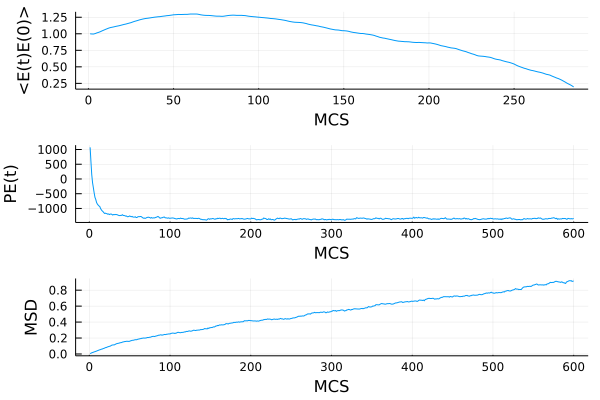

In [3]:
function mc_main(rho::Float64,jump::Float64,timesteps::Int64)
    n = 256
    xpos,ypos,zpos,box_size = populate(rho,n)
    temp = 1.32
	beta = 1.0/temp

	seeker = zeros(Int64,n)
	nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
	xpos_snap = copy(xpos)
	ypos_snap = copy(ypos)
	zpos_snap = copy(zpos)
    xpos_ref = copy(xpos)
	ypos_ref = copy(ypos)
	zpos_ref = copy(zpos)
	pe = zeros(timesteps)
    pressure = zeros(timesteps)
    ppmsd = zeros(timesteps)
    acc_ratio = [0.0,0.0]
	dRx::Float64 = 0.0
	dRy::Float64 = 0.0
	dRz::Float64 = 0.0
    
	for t = 1:timesteps
		for i = 1:n
            mcmove!(xpos,ypos,zpos,nlist,seeker,box_size,n,jump,beta,acc_ratio)
        end
        pe[t],pressure[t] = calc_tot_energy(xpos,ypos,zpos,nlist,seeker,box_size,n)
        pressure[t] = pressure[t] + rho*temp
		dR_max1 = 0.0
		dR_max2 = 0.0
        msd = 0.0
		for i = 1:n
            drx = xpos[i] - xpos_ref[i]
            dry = ypos[i] - ypos_ref[i]
            drz = zpos[i] - zpos_ref[i]
            msd = msd + drx*drx + dry*dry + drz*drz
            
			dRx = xpos[i] - xpos_snap[i]
			dRy = ypos[i] - ypos_snap[i]
			dRz = zpos[i] - zpos_snap[i]
			dRx,dRy,dRz = apply_pbcs(dRx,dRy,dRz,box_size)
			dx = dRx*dRx + dRy*dRy + dRz*dRz
			dx = sqrt(dx)
			if(dx>dR_max1)
				dR_max2 = dR_max1
				dR_max1 = dx
			elseif(dx>dR_max2)
				dR_max2 = dx
			end
		end
        msd = msd/n
        ppmsd[t] = msd
		if(dR_max1 + dR_max2 > 0.5)
			nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
			xpos_snap = copy(xpos)
			ypos_snap = copy(ypos)
			zpos_snap = copy(zpos)
		end
	end
    acc_ratio[1] = acc_ratio[1]/(n*timesteps)
    acc_ratio[1] = 1 - acc_ratio[1]
	return pe,ppmsd,pressure
end

function keep_positive(x::Array{Float64,1})
    ibreak = 1
    for i in 1:size(x,1)
        if x[i] < 0.2
            ibreak = i
            break
        end
    end
    return x[1:ibreak]
end

function tcf!(timecor::Array{Float64,1},x::Array{Float64,1})
    fill!(timecor,zero(Float64))
    for indx in 1:floor(Int64,size(x,1)/2)+1
        gap = indx - 1
        for timeorigin in 1:size(x,1)-gap
            timecor[indx] = timecor[indx] + x[timeorigin]*x[timeorigin + gap]
        end
        timecor[indx] = timecor[indx]/(size(x,1) - gap)
    end
    avgx = sum(x)/size(x,1)
    timecor .= timecor .- avgx*avgx
    timecor .= timecor./(timecor[1])
end

pe,ppmsd,pressure = mc_main(0.8,0.03,600)
timecor_pe = zeros(301)
tcf!(timecor_pe,pe)
p1 = plot(keep_positive(timecor_pe),xlabel="MCS",ylabel="<E(t)E(0)>",legend=false)
p2 = plot(pe,xlabel="MCS",ylabel="PE(t)",legend=false)
p3 = plot(ppmsd,xlabel="MCS",ylabel="MSD",legend=false)
plot(p1,p2,p3,layout=(3,1),heights=[2.0,2.0,2.0])

We now have a clear indication of $\tau$, which we choose based on the density. For $\rho=0.8$ we see that the time correlation drops though the MSD takes lot of MCS to reach $1.0$. For this case MCS of 2000 should suffice as the equilibration run. And clearly for lower densities the equilibration runs are shorter. We stick to 2000 MCS for all cases.

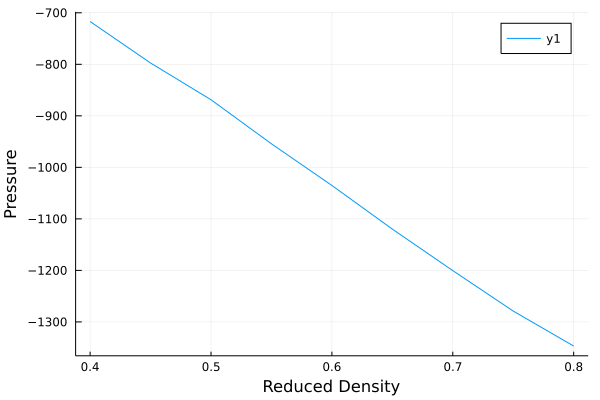

(-76.86507883713176, -1597.6459343848867)


In [9]:
using DelimitedFiles
using CurveFit

function mc_main(rho::Float64,jump::Float64,tprod::Int64)
    n = 256
    xpos,ypos,zpos,box_size = populate(rho,n)
    temp = 1.32
	beta = 1.0/temp

	seeker = zeros(Int64,n)
	nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
	xpos_snap = copy(xpos)
	ypos_snap = copy(ypos)
	zpos_snap = copy(zpos)

    pressure = zeros(tprod)
    s_pressure = 0.0
    acc_ratio = [0.0,0.0]

	dRx::Float64 = 0.0
	dRy::Float64 = 0.0
	dRz::Float64 = 0.0
    
	for t = 1:2000
		for i = 1:n
            mcmove!(xpos,ypos,zpos,nlist,seeker,box_size,n,jump,beta,acc_ratio)
        end
        #pressure[t] = calc_tot_energy(xpos,ypos,zpos,nlist,seeker,box_size,n)
        #pressure[t] = pressure[t] + rho*temp
		dR_max1 = 0.0
		dR_max2 = 0.0
        msd = 0.0
		for i = 1:n
			dRx = xpos[i] - xpos_snap[i]
			dRy = ypos[i] - ypos_snap[i]
			dRz = zpos[i] - zpos_snap[i]
			dRx,dRy,dRz = apply_pbcs(dRx,dRy,dRz,box_size)
			dx = dRx*dRx + dRy*dRy + dRz*dRz
			dx = sqrt(dx)
			if(dx>dR_max1)
				dR_max2 = dR_max1
				dR_max1 = dx
			elseif(dx>dR_max2)
				dR_max2 = dx
			end
		end

		if(dR_max1 + dR_max2 > 0.5)
			nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
			xpos_snap = copy(xpos)
			ypos_snap = copy(ypos)
			zpos_snap = copy(zpos)
		end
	end
    for t = 1:tprod
		for i = 1:n
            mcmove!(xpos,ypos,zpos,nlist,seeker,box_size,n,jump,beta,acc_ratio)
        end
        pressure[t] = calc_tot_energy(xpos,ypos,zpos,nlist,seeker,box_size,n)
        s_pressure = (sum(pressure)/tprod) + rho*temp
		dR_max1 = 0.0
		dR_max2 = 0.0
        msd = 0.0
		for i = 1:n
			dRx = xpos[i] - xpos_snap[i]
			dRy = ypos[i] - ypos_snap[i]
			dRz = zpos[i] - zpos_snap[i]
			dRx,dRy,dRz = apply_pbcs(dRx,dRy,dRz,box_size)
			dx = dRx*dRx + dRy*dRy + dRz*dRz
			dx = sqrt(dx)
			if(dx>dR_max1)
				dR_max2 = dR_max1
				dR_max1 = dx
			elseif(dx>dR_max2)
				dR_max2 = dx
			end
		end

		if(dR_max1 + dR_max2 > 0.5)
			nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
			xpos_snap = copy(xpos)
			ypos_snap = copy(ypos)
			zpos_snap = copy(zpos)
		end
	end
	return s_pressure
end

step = 1
pv = zeros(9)
#for rho in 0.4:0.05:0.8
#    jump = 0.06 - (step-1)*0.005
#    pv[step] = mc_main(rho,jump,5000)
#    step = step + 1
#end
#open("eos","w") do io
#    writedlm(io,pv)
#end

pv = readdlm("eos")
println(linear_fit(0.4:0.05:0.8,pv))

Plots.display(plot(0.4:0.05:0.8,pv,xlabel="Reduced Density",ylabel="Pressure"))

We see $P = a + b\rho$ with $a$ and $b$ as the fitting parameters. Therefore,
\begin{eqnarray}
P &=& a + \frac{bN}{V} \\
V &=& \frac{bN}{P - a} \\
\kappa_T &=& -\frac{1}{V}\frac{\partial V}{\partial P} \\
\kappa_T &=& \frac{1}{V}\frac{bN}{(P - a)^2} \\
\kappa_T &=& \frac{1}{(P - a)} \\
\kappa_T &=& \frac{1}{b\rho}
\end{eqnarray}

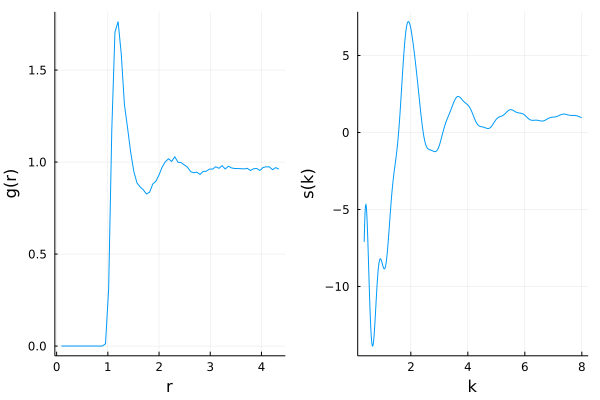

In [11]:
function mc_main(rho::Float64,jump::Float64,tprod::Int64)
    n = 256
    xpos,ypos,zpos,box_size = populate(rho,n)
    temp = 1.32
	beta = 1.0/temp

	seeker = zeros(Int64,n)
	nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
	xpos_snap = copy(xpos)
	ypos_snap = copy(ypos)
	zpos_snap = copy(zpos)

    pressure = zeros(tprod)
    s_pressure = 0.0
    acc_ratio = [0.0,0.0]

	dRx::Float64 = 0.0
	dRy::Float64 = 0.0
	dRz::Float64 = 0.0
    
	for t = 1:2000
		for i = 1:n
            mcmove!(xpos,ypos,zpos,nlist,seeker,box_size,n,jump,beta,acc_ratio)
        end
        #pressure[t] = calc_tot_energy(xpos,ypos,zpos,nlist,seeker,box_size,n)
        #pressure[t] = pressure[t] + rho*temp
		dR_max1 = 0.0
		dR_max2 = 0.0
        msd = 0.0
		for i = 1:n
			dRx = xpos[i] - xpos_snap[i]
			dRy = ypos[i] - ypos_snap[i]
			dRz = zpos[i] - zpos_snap[i]
			dRx,dRy,dRz = apply_pbcs(dRx,dRy,dRz,box_size)
			dx = dRx*dRx + dRy*dRy + dRz*dRz
			dx = sqrt(dx)
			if(dx>dR_max1)
				dR_max2 = dR_max1
				dR_max1 = dx
			elseif(dx>dR_max2)
				dR_max2 = dx
			end
		end

		if(dR_max1 + dR_max2 > 0.5)
			nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
			xpos_snap = copy(xpos)
			ypos_snap = copy(ypos)
			zpos_snap = copy(zpos)
		end
	end
    g = zeros(70)
    r = zeros(70)
    k_tot = floor(Int64,((8 - (pi/box_size))/0.01)) + 1
    sk = zeros(k_tot)
    kpoints = zeros(k_tot)
    count = 0.0
    for t = 1:tprod
		for i = 1:n
            mcmove!(xpos,ypos,zpos,nlist,seeker,box_size,n,jump,beta,acc_ratio)
        end
        _,pressure[t] = calc_tot_energy(xpos,ypos,zpos,nlist,seeker,box_size,n)
        s_pressure = (sum(pressure)/tprod) + rho*temp
		dR_max1 = 0.0
		dR_max2 = 0.0
        msd = 0.0
		for i = 1:n
			dRx = xpos[i] - xpos_snap[i]
			dRy = ypos[i] - ypos_snap[i]
			dRz = zpos[i] - zpos_snap[i]
			dRx,dRy,dRz = apply_pbcs(dRx,dRy,dRz,box_size)
			dx = dRx*dRx + dRy*dRy + dRz*dRz
			dx = sqrt(dx)
			if(dx>dR_max1)
				dR_max2 = dR_max1
				dR_max1 = dx
			elseif(dx>dR_max2)
				dR_max2 = dx
			end
		end

		if(dR_max1 + dR_max2 > 0.5)
			nlist,seeker = verlet_list_new(xpos,ypos,zpos,box_size,n)
			xpos_snap = copy(xpos)
			ypos_snap = copy(ypos)
			zpos_snap = copy(zpos)
		end
        if(t%100==0)
            g_loc,r_loc,sk_loc,kpoints_loc= grsk(xpos,ypos,zpos,box_size,n)
            g .= g .+ g_loc
            r .= r .+ r_loc
            sk .= sk .+ sk_loc
            kpoints .= kpoints .+ kpoints_loc
            count = count +1
        end

    end
    g .= g./count
    r .= r./count
    sk .= sk./count
    kpoints .= kpoints./count
    p1 = plot(r,g,xlabel="r", ylabel="g(r)",legend=false)
    p2 = plot(kpoints,sk,xlabel="k", ylabel="s(k)",legend=false)
    plot(p1,p2,layout=(1,2))
	#return s_pressure
end


function grsk(xpos::Array{Float64,1},ypos::Array{Float64,1},zpos::Array{Float64,1},box_size::Float64,n::Int64)
    iBox = 1.0/box_size
    nhis = 70
    g = zeros(nhis)
    r = zeros(nhis)
    delg = box_size/(2*nhis)
    for i in 1:n-1
        for j in i+1:n
            dx = xpos[i] - xpos[j]
            dy = ypos[i] - ypos[j]
            dz = zpos[i] - zpos[j]
            dx = dx - box_size*round(dx*iBox) 
            dy = dy - box_size*round(dy*iBox)
            dz = dz - box_size*round(dz*iBox)
            dr = sqrt(dx*dx + dy*dy + dz*dz)
            if(dr < 0.5*box_size)
                ig = floor(Int64,dr/delg)
                g[ig+1] = g[ig+1] + 2
            end
        end
    end
    for i in 1:nhis
        r[i] = delg*(i + 0.5)
        vb = ((i+1)^3 - i^3)*(delg^3)
        nid = (4.0/3)*pi*vb*n/(box_size^3)
        g[i] = g[i]/(n*nid)
    end
    ktot = floor(Int64,((8 - ((pi)/box_size))/0.01)) + 1
    kpoints = zeros(ktot)
    sk = zeros(ktot)
    counter = 1
    for k in (pi/box_size):0.01:8
        kpoints[counter] = k
        integral = 0.0
        for i in 1:nhis
            integral = integral + r[i]*r[i]*(g[i]-1.0)*sinc(k*r[i])
        end
        integral = integral*4*pi*n/(box_size^3)
        integral = integral + 1.0
        sk[counter] = integral
        counter = counter + 1
    end
    return g,r,sk,kpoints
end
mc_main(0.4,0.06,5000)            